## Машинное обучение в бизнесе
### Урок 6. Задача look-alike

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

Для практики взят датасет https://archive.ics.uci.edu/dataset/73/mushroom

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

In [2]:
df = pd.read_csv("./mushrooms.data",header=None, names=(
'target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring',
'stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat'
))
df.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
TARGET = 'target'
df[TARGET].unique()

array(['p', 'e'], dtype=object)

<AxesSubplot:>

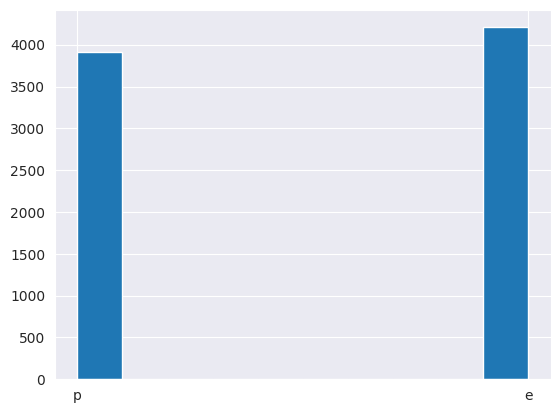

In [4]:
df[TARGET].hist()

Классы:
- p - poisonous
- e - edible

Заменим все edible на 1, а poisonous соответственно на 0

Проверим информативность признаков

In [5]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

gill-attachment: 97.41507%
f    7914
a     210
Name: gill-attachment, dtype: int64

veil-type: 100.00000%
p    8124
Name: veil-type, dtype: int64

veil-color: 97.53816%
w    7924
n      96
o      96
y       8
Name: veil-color, dtype: int64



Как видим признаки gill-attachment, veil-type, vail-color не являются информативными. Отбросим из

In [6]:
exclude_columns = ['veil-type', 'veil-color', 'gill-attachment']

In [7]:
df.drop(exclude_columns, axis=1, inplace=True)
df.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,c,n,k,e,e,s,s,w,w,o,p,k,s,u
1,e,x,s,y,t,a,c,b,k,e,c,s,s,w,w,o,p,n,n,g
2,e,b,s,w,t,l,c,b,n,e,c,s,s,w,w,o,p,n,n,m
3,p,x,y,w,t,p,c,n,n,e,e,s,s,w,w,o,p,k,s,u
4,e,x,s,g,f,n,w,b,k,t,e,s,s,w,w,o,e,n,a,g


In [8]:
df[TARGET] = df[TARGET].map({'p':0,'e':1})

In [9]:
X = df.drop(columns=[TARGET])
COLUMNS = list(X.columns)
y = df[TARGET]

encoder = LabelEncoder()
X_enc = X[COLUMNS].apply(encoder.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=0)
X_test

,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat
380,5,3,4,1,6,0,1,7,0,3,2,2,7,7,1,4,2,3,5
3641,2,3,3,1,5,0,0,7,1,1,2,2,3,3,1,4,2,5,0
273,5,3,9,1,0,0,0,4,0,2,2,2,7,7,1,4,3,2,3
1029,5,2,8,0,5,1,0,4,1,3,2,2,7,7,1,0,2,0,1
684,5,0,4,1,5,0,0,7,1,1,2,2,6,7,1,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,5,2,8,0,5,1,0,3,1,3,0,0,7,7,1,0,2,3,1
6181,2,2,4,0,7,0,1,0,1,0,1,1,6,7,1,0,7,4,0
6228,5,3,2,0,7,0,1,0,1,0,2,1,6,6,1,0,7,4,0
554,5,2,9,1,3,0,0,4,0,2,2,2,7,7,1,4,2,3,1


In [10]:
model = RidgeClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [11]:
metrics_ = []
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.nanargmax(fscore)

roc_auc_score_ = metrics.roc_auc_score(y_test, y_preds)
metrics_.append([
    'supervisor',
    thresholds[ix],
    fscore[ix],
    precision[ix],
    recall[ix],
    roc_auc_score_
])

In [12]:
metrics_

[['supervisor',
  1,
  0.9449112978524743,
  0.9361702127659575,
  0.9538171536286523,
  0.941341566505048]]

**далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть**

In [38]:
def split_data_pu(data, y, f=.5):
    new_data = data.copy()
    new_data['target'] = y

    positions = list(new_data[new_data['target'] == 1].sample(frac=1, random_state=42).index)
    np.random.shuffle(positions)
    positions = positions[:int(np.ceil(f*len(positions)))]
    new_data['pu_target'] = -1
    new_data.loc[positions, 'pu_target'] = 1

    new_data = new_data.sample(frac=1)
    neg_sample = new_data[new_data['pu_target']==-1][:len(new_data[new_data['pu_target']==1])]
    sample_test = new_data[new_data['pu_target']==-1][len(new_data[new_data['pu_target']==1]):]
    pos_sample = new_data[new_data['pu_target']==1]
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    return sample_train.drop(['target','pu_target'], axis=1), sample_train['pu_target'], sample_test.drop(['target','pu_target'], axis=1), sample_test['pu_target']


In [33]:
X_test, y_test, X_train, y_train = split_data_pu(X_enc, y, .5)

model = RidgeClassifier(random_state=42)
# model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.nanargmax(fscore)

roc_auc_score_ = metrics.roc_auc_score(y_test, y_preds)
metrics_.append([
    'pu',
    thresholds[ix],
    fscore[ix],
    precision[ix],
    recall[ix],
    roc_auc_score_
])

In [35]:
pd.DataFrame(metrics_,
             columns=('classifier', 'thresholds', 'fscore', 'precision', 'recall', 'roc_auc'))

,classifier,thresholds,fscore,precision,recall,roc_auc
0,supervisor,1,0.944911,0.93617,0.953817,0.941342
1,pu,-1,0.666667,0.50000,1.000000,0.500000


**Поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)**

In [46]:
metrics_ = []
for f_ in np.linspace(0.1, .9, 9):
    X_test, y_test, X_train, y_train = split_data_pu(X_enc, y, f_)
    model = RidgeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_preds)
    fscore = (2 * precision * recall) / (precision + recall)

    ix = np.nanargmax(fscore)

    roc_auc_score_ = metrics.roc_auc_score(y_test, y_preds)
    metrics_.append([
        f_,
        thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix],
        roc_auc_score_
    ])

In [47]:
pd.DataFrame(metrics_,
             columns=('fraction', 'thresholds', 'fscore', 'precision', 'recall', 'roc_auc'))

,fraction,thresholds,fscore,precision,recall,roc_auc
0,0.1,-1,0.666667,0.5,1.0,0.5
1,0.2,-1,0.666667,0.5,1.0,0.5
2,0.3,-1,0.666667,0.5,1.0,0.5
3,0.4,-1,0.666667,0.5,1.0,0.5
4,0.5,-1,0.666667,0.5,1.0,0.5
5,0.6,-1,0.666667,0.5,1.0,0.5
6,0.7,-1,0.666667,0.5,1.0,0.5
7,0.8,-1,0.666667,0.5,1.0,0.5
8,0.9,-1,0.666667,0.5,1.0,0.5
